# Computing Node2Vec embeddings with the GDS

This notebook shows how to compute node2vec embeddings with the GDS for a graph stored into Neo4j. First, the projected graph is created, then the embeddings computed and streamed into a pandas DataFrame. Then we run the Louvain algorithm to extract the community structure of the graph and store this information as a new column in the DataFrame. Finally, we plot the embedding result on a 2D plane, using different color

In [5]:
# update PYTHONPATH to be able to load utils module
import sys
import os
sys.path.append(os.path.join(os.curdir, ".."))
# sys.path

import pandas as pd
pd.set_option('display.max_colwidth', None)

In [3]:
from graphdatascience import GraphDataScience
gds = GraphDataScience("bolt://localhost:7687", auth=("neo4j", "admin123"))

In [151]:
from utils import create_projected_graph
projected_graph_object = create_projected_graph(
    gds,
    graph_name="pgraph",
    node_spec="Node",  
    relationship_spec={"RELATED_TO": {"orientation": "UNDIRECTED"}}
)

In [142]:
res = gds.beta.node2vec.stream(
    projected_graph_object,
    walkLength=20,
    embeddingDimension=18,
    inOutFactor=10,
    # returnFactor=0.1,
)
res.head(2)

,nodeId,embedding
0,0,"[0.8960922956466675, 0.040399227291345596, 0.33585506677627563, 0.15637916326522827, -0.26111459732055664, 0.2998621165752411, 0.041738227009773254, 0.014968019910156727, -0.540949821472168, 1.5749553442001343, -0.18568450212478638, -0.09542407840490341, -0.14897693693637848, -0.5432039499282837, 0.1776922643184662, -0.028899716213345528, 0.6924341320991516, -0.06455353647470474]"
1,1,"[0.8536390066146851, 0.22371743619441986, 0.2837353050708771, 0.15514083206653595, -0.16514518857002258, 0.46343693137168884, 0.002305456670001149, -0.2135782688856125, -0.6072603464126587, 1.334747314453125, -0.1328449845314026, -0.12888579070568085, -0.08751469850540161, -0.4089171588420868, -0.06762059777975082, 0.026834294199943542, 0.9950464963912964, -0.018991971388459206]"


In [143]:
res["id"] = [n.get("id") for n in gds.util.asNodes(res['nodeId'].to_list())]
res.head(2)

,nodeId,embedding,id
0,0,"[0.8960922956466675, 0.040399227291345596, 0.33585506677627563, 0.15637916326522827, -0.26111459732055664, 0.2998621165752411, 0.041738227009773254, 0.014968019910156727, -0.540949821472168, 1.5749553442001343, -0.18568450212478638, -0.09542407840490341, -0.14897693693637848, -0.5432039499282837, 0.1776922643184662, -0.028899716213345528, 0.6924341320991516, -0.06455353647470474]",0
1,1,"[0.8536390066146851, 0.22371743619441986, 0.2837353050708771, 0.15514083206653595, -0.16514518857002258, 0.46343693137168884, 0.002305456670001149, -0.2135782688856125, -0.6072603464126587, 1.334747314453125, -0.1328449845314026, -0.12888579070568085, -0.08751469850540161, -0.4089171588420868, -0.06762059777975082, 0.026834294199943542, 0.9950464963912964, -0.018991971388459206]",21


In [144]:
embedding_list = res.embedding.to_list()
f_names = [f"e_{k}" for k in range(len(embedding_list[0]))]
res.loc[:,f_names] = embedding_list
res.head(2)

,nodeId,embedding,id,e_0,e_1,e_2,e_3,e_4,e_5,e_6,...,e_8,e_9,e_10,e_11,e_12,e_13,e_14,e_15,e_16,e_17
0,0,"[0.8960922956466675, 0.040399227291345596, 0.33585506677627563, 0.15637916326522827, -0.26111459732055664, 0.2998621165752411, 0.041738227009773254, 0.014968019910156727, -0.540949821472168, 1.5749553442001343, -0.18568450212478638, -0.09542407840490341, -0.14897693693637848, -0.5432039499282837, 0.1776922643184662, -0.028899716213345528, 0.6924341320991516, -0.06455353647470474]",0,0.896092,0.040399,0.335855,0.156379,-0.261115,0.299862,0.041738,...,-0.54095,1.574955,-0.185685,-0.095424,-0.148977,-0.543204,0.177692,-0.028900,0.692434,-0.064554
1,1,"[0.8536390066146851, 0.22371743619441986, 0.2837353050708771, 0.15514083206653595, -0.16514518857002258, 0.46343693137168884, 0.002305456670001149, -0.2135782688856125, -0.6072603464126587, 1.334747314453125, -0.1328449845314026, -0.12888579070568085, -0.08751469850540161, -0.4089171588420868, -0.06762059777975082, 0.026834294199943542, 0.9950464963912964, -0.018991971388459206]",21,0.853639,0.223717,0.283735,0.155141,-0.165145,0.463437,0.002305,...,-0.60726,1.334747,-0.132845,-0.128886,-0.087515,-0.408917,-0.067621,0.026834,0.995046,-0.018992


In [145]:
louvain = gds.louvain.stream(projected_graph_object)
louvain.head(2)

Louvain:   0%|          | 0/100 [00:00<?, ?%/s]

,nodeId,communityId,intermediateCommunityIds
0,0,63,None
1,1,63,None


In [146]:
louvain_reindexed = louvain.set_index("nodeId")
res_reindexed = res.set_index("nodeId")
res_reindexed.head(2)

,embedding,id,e_0,e_1,e_2,e_3,e_4,e_5,e_6,e_7,e_8,e_9,e_10,e_11,e_12,e_13,e_14,e_15,e_16,e_17
nodeId,,,,,,,,,,,,,,,,,,,,
0,"[0.8960922956466675, 0.040399227291345596, 0.33585506677627563, 0.15637916326522827, -0.26111459732055664, 0.2998621165752411, 0.041738227009773254, 0.014968019910156727, -0.540949821472168, 1.5749553442001343, -0.18568450212478638, -0.09542407840490341, -0.14897693693637848, -0.5432039499282837, 0.1776922643184662, -0.028899716213345528, 0.6924341320991516, -0.06455353647470474]",0,0.896092,0.040399,0.335855,0.156379,-0.261115,0.299862,0.041738,0.014968,-0.54095,1.574955,-0.185685,-0.095424,-0.148977,-0.543204,0.177692,-0.028900,0.692434,-0.064554
1,"[0.8536390066146851, 0.22371743619441986, 0.2837353050708771, 0.15514083206653595, -0.16514518857002258, 0.46343693137168884, 0.002305456670001149, -0.2135782688856125, -0.6072603464126587, 1.334747314453125, -0.1328449845314026, -0.12888579070568085, -0.08751469850540161, -0.4089171588420868, -0.06762059777975082, 0.026834294199943542, 0.9950464963912964, -0.018991971388459206]",21,0.853639,0.223717,0.283735,0.155141,-0.165145,0.463437,0.002305,-0.213578,-0.60726,1.334747,-0.132845,-0.128886,-0.087515,-0.408917,-0.067621,0.026834,0.995046,-0.018992


In [147]:
res_reindexed["louvain"] = louvain_reindexed.communityId

In [148]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
res_reindexed["louvain_enc"] = le.fit_transform(res_reindexed.louvain)
res_reindexed.head(2)

,embedding,id,e_0,e_1,e_2,e_3,e_4,e_5,e_6,e_7,...,e_10,e_11,e_12,e_13,e_14,e_15,e_16,e_17,louvain,louvain_enc
nodeId,,,,,,,,,,,,,,,,,,,,,
0,"[0.8960922956466675, 0.040399227291345596, 0.33585506677627563, 0.15637916326522827, -0.26111459732055664, 0.2998621165752411, 0.041738227009773254, 0.014968019910156727, -0.540949821472168, 1.5749553442001343, -0.18568450212478638, -0.09542407840490341, -0.14897693693637848, -0.5432039499282837, 0.1776922643184662, -0.028899716213345528, 0.6924341320991516, -0.06455353647470474]",0,0.896092,0.040399,0.335855,0.156379,-0.261115,0.299862,0.041738,0.014968,...,-0.185685,-0.095424,-0.148977,-0.543204,0.177692,-0.028900,0.692434,-0.064554,63,0
1,"[0.8536390066146851, 0.22371743619441986, 0.2837353050708771, 0.15514083206653595, -0.16514518857002258, 0.46343693137168884, 0.002305456670001149, -0.2135782688856125, -0.6072603464126587, 1.334747314453125, -0.1328449845314026, -0.12888579070568085, -0.08751469850540161, -0.4089171588420868, -0.06762059777975082, 0.026834294199943542, 0.9950464963912964, -0.018991971388459206]",21,0.853639,0.223717,0.283735,0.155141,-0.165145,0.463437,0.002305,-0.213578,...,-0.132845,-0.128886,-0.087515,-0.408917,-0.067621,0.026834,0.995046,-0.018992,63,0


In [149]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embedding_pca = pca.fit_transform(res_reindexed.loc[:,f_names])
embedding_pca

array([[-0.09279807, -1.43875905],
       [ 0.39437243, -1.40805173],
       [ 0.02913975, -1.26998793],
       ...,
       [-0.84933325, -0.05486688],
       [-1.30471251,  0.04010234],
       [-1.00144749, -0.13983254]])

''

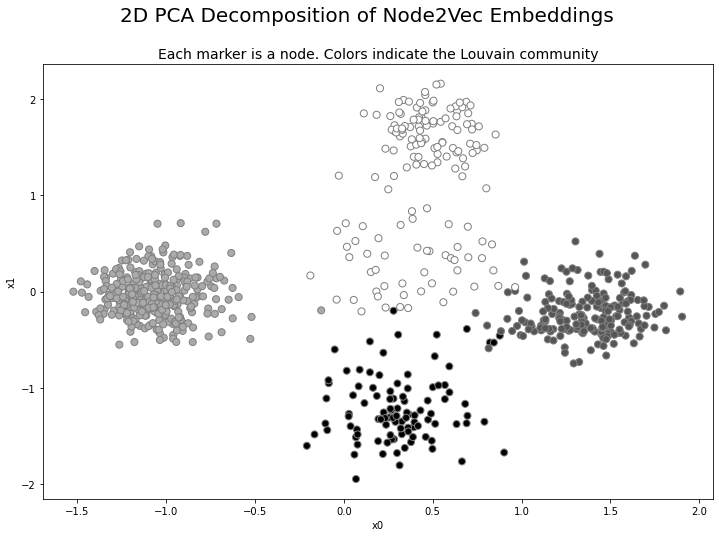

In [150]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.scatter(*zip(*embedding_pca), c=res_reindexed.louvain_enc, cmap="gray", edgecolor="grey", s=50)
plt.xlabel("x0")
plt.ylabel("x1")
plt.suptitle("2D PCA Decomposition of Node2Vec Embeddings", fontsize=20)
plt.title("Each marker is a node. Colors indicate the Louvain community", fontsize=14)
;

In [70]:
# res_reindexed.to_csv("node2vec_results.csv")